In [1]:
import os
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [2]:
# Setup working directory and relative filepaths
current_dir = os.curdir
data_dir = os.path.join(current_dir, "data")
output_dir = os.path.join(current_dir, "data_clean")

# Get data path
abc_data_dir = os.path.join(data_dir, "abc-news.csv")
bbc_data_dir = os.path.join(data_dir, "bbc-news.csv")
cbs_data_dir = os.path.join(data_dir, "cbs-news.csv")
cnn_data_dir = os.path.join(data_dir, "cnn-news.csv")

# Read csv data
abc_data_csv = pd.read_csv(abc_data_dir, encoding="utf-16")
bbc_data_csv = pd.read_csv(bbc_data_dir, encoding="utf-16")
cbs_data_csv = pd.read_csv(cbs_data_dir, encoding="utf-16")
cnn_data_csv = pd.read_csv(cnn_data_dir, encoding="utf-16")

In [3]:
abc_data_df = pd.DataFrame(abc_data_csv.copy())
bbc_data_df = pd.DataFrame(bbc_data_csv.copy())
cbs_data_df = pd.DataFrame(cbs_data_csv.copy())
cnn_data_df = pd.DataFrame(cnn_data_csv.copy())

In [4]:
print("abc: " + str(len(abc_data_df)))
print("bbc: " + str(len(bbc_data_df)))
print("cbs: " + str(len(cbs_data_df)))
print("cnn: " + str(len(cnn_data_df)))

abc: 43280
bbc: 21119
cbs: 35085
cnn: 31696


In [5]:
# Remove columns from Dataframe
col_ls = ['id', 'page_id', 'message', 'description', 'caption', 'picture']
abc_data_df.drop(columns = col_ls, inplace = True)
bbc_data_df.drop(columns = col_ls, inplace = True)
cbs_data_df.drop(columns = col_ls, inplace = True)
cnn_data_df.drop(columns = col_ls, inplace = True)

In [6]:
# Determine how many post_types and status_types and factorize types
post_types_unique = pd.unique(abc_data_df['post_type'])
post_types_factorize = pd.factorize(post_types_unique, sort=True)[0]
status_types_unique = pd.unique(abc_data_df['status_type'])
status_types_unique = [i for i in status_types_unique if str(i) != 'nan']
status_types_factorize = pd.factorize(status_types_unique, sort=True)[0]

In [7]:
# Create dictionary for post_types and status_types
post_types_dict = dict(zip(post_types_unique, post_types_factorize))
status_types_dict = dict(zip(status_types_unique, status_types_factorize))

In [8]:
# Define function to assign kv pairs to post_types and status_types
def post_cat(x):
    for type, category in post_types_dict.items():
        if x in type:
            return category

def status_cat(x):
    for type, category in status_types_dict.items():
        try:
            if x in type:
                return category
        except TypeError:
            return -1

# Apply function to DataFrame
abc_data_df['post_category'] = abc_data_df['post_type'].apply(post_cat)
abc_data_df['status_category'] = abc_data_df['status_type'].apply(status_cat)

In [9]:
# Calculate total reacts
react_col = ['likes_count', 'comments_count', 'shares_count', 'love_count',
            'wow_count', 'haha_count', 'sad_count', 'thankful_count', 'angry_count',]

abc_data_df['total_reacts'] = abc_data_df[react_col].sum(axis=1)

# Transform 'posted_at' to datetime.datime object
abc_data_df['posted_at'] = pd.to_datetime(abc_data_df['posted_at'])

# Round datetime.datetime object to the nearest hour recursively using round_hour method
def round_hour(t):
    t_start_hr = t.replace(minute=0, second=0, microsecond=0) # round to down to nearest hour
    t = t_start_hr
    return t

abc_data_df['posted_at'] = abc_data_df['posted_at'].apply(round_hour)

# Store date and time in new columns using list comprehension 
abc_data_df['date_posted'] = [i.date() for i in abc_data_df['posted_at']]
abc_data_df['time_posted'] = [i.time() for i in abc_data_df['posted_at']]
abc_data_df.drop(columns=['posted_at'], inplace=True)

In [10]:
# Define function to determine sentiment of abc_data_df['name']
def analyze_sentiment(headline):
    analysis = TextBlob(str(headline))
    return analysis.sentiment # returns sentiment, subjectivity

# Create new column on abc_data_df called 'Sentiment' and store sentiment values using analyze_sentiment method
abc_data_df[['name_sentiment', 'name_subjectivity']] = np.array([analyze_sentiment(str(headline)) for headline in abc_data_df['name']])

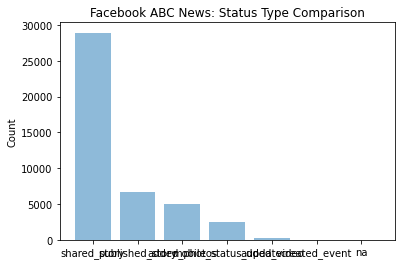

In [11]:
objects = status_types_unique
objects.append('na')
y_pos = np.arange(len(objects))
performance = abc_data_df['status_category'].value_counts()
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Facebook ABC News: Status Type Comparison')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

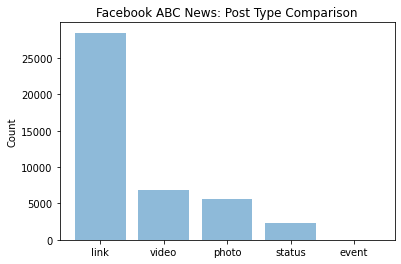

In [12]:
objects = post_types_unique
y_pos = np.arange(len(objects))
performance = abc_data_df['post_category'].value_counts()
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Facebook ABC News: Post Type Comparison')
plt.show

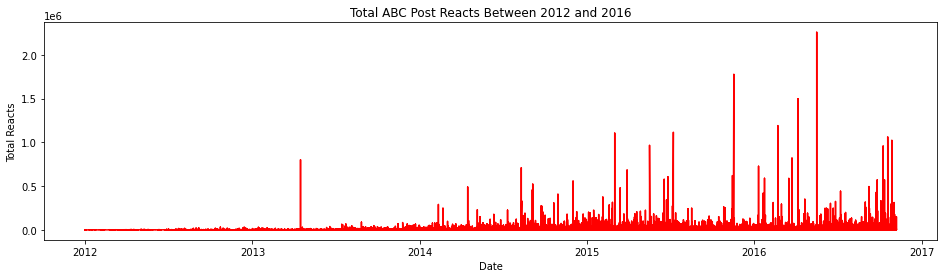

In [13]:
# Total reacts over time
time_reacts = pd.Series(data=abc_data_df['total_reacts'].values, index=abc_data_df['date_posted'])
time_reacts.plot(figsize=(16,4), color='r')
plt.ylabel('Total Reacts')
plt.xlabel('Date')
plt.title('Total ABC Post Reacts Between 2012 and 2016')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

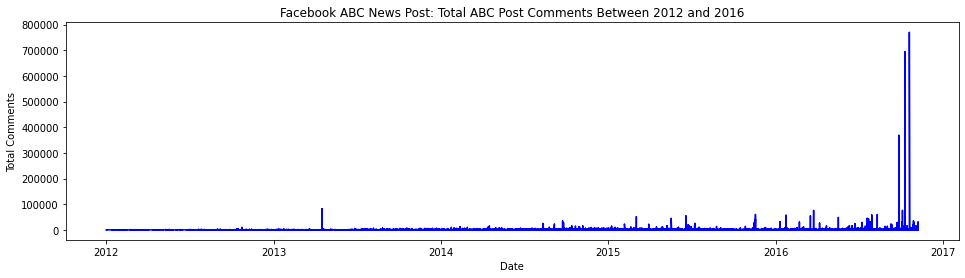

In [14]:
# Total comments over time
chart = plt.figure(4)
time_comments = pd.Series(data=abc_data_df['comments_count'].values, index=abc_data_df['date_posted'])
time_comments.plot(figsize=(16,4), color='b')
plt.ylabel('Total Comments')
plt.xlabel('Date')
plt.title('Facebook ABC News Post: Total ABC Post Comments Between 2012 and 2016')
plt.show

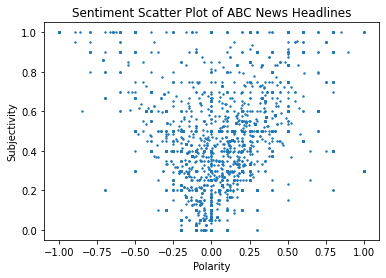

In [15]:
# Scatter plot of x=sentiment y=name_subjectivity
# Store name_sentiment and name_subjectivity to an array
# Sample data n=10000
abc_data_sample = abc_data_df.sample(9000)
x_sentimentArray = abc_data_sample['name_sentiment'].to_numpy()
y_subjectivityArray = abc_data_sample['name_subjectivity'].to_numpy()
plt.scatter(x_sentimentArray, y_subjectivityArray, s=2)
plt.ylabel('Subjectivity')
plt.xlabel('Polarity')
plt.title('Sentiment Scatter Plot of ABC News Headlines')
plt.show()


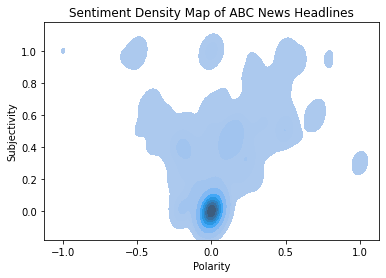

In [16]:
# Show sentiment density using seaborn
sentiment_density = sns.kdeplot(data=abc_data_sample, y='name_subjectivity', x='name_sentiment', fill=True)
sentiment_density.set(xlabel='Polarity', ylabel='Subjectivity', title='Sentiment Density Map of ABC News Headlines')
plt.show()